_Neural Data Analysis_

Lecturer: Prof. Dr. Philipp Berens

Tutors: Sarah Strauss, Ziwei Huang

Summer term 2021

Name: Nishad Singhi (5619175) | 

# Coding Lab 7



1) what is v doing in task 1?

In [89]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.optimize as opt
import scipy.io as io
import scipy as sp
from scipy.special import factorial

mpl.rc("savefig", dpi=72)

import itertools

sns.set_style('whitegrid')
%matplotlib inline

## Task 1: Fit RF on simulated data

We will start  with toy data generated from an LNP model neuron to make sure everything works right. The model LNP neuron consists of one Gaussian linear filter, an exponential nonlinearity and a Poisson spike count generator. We look at it in discrete time with time bins of width $\delta t$. The model is:

$$
c_t \sim Poisson(r_t)\\
r_t = \exp(w^T s_t) \cdot \Delta t \cdot R
$$

Here, $c_t$ is the spike count in time window $t$ of length $\Delta t$, $s_t$ is the stimulus and $w$ is the receptive field of the neuron. The receptive field variable `w` is 15 × 15 pixels and normalized to $||w||=1$. A stimulus frame is a 15 × 15 pixel image, for which we use uncorrelated checkerboard noise. R can be used to bring the firing rate into the right regime (e.g. by setting $R=50$).   

For computational ease, we reformat the stimulus and the receptive field in a 225 by 1 array. The function ```sampleLNP``` can be used to generate data from this model. It returns a spike count vector `c` with samples from the model (dimensions: 1 by nT = $T/\Delta t$), a stimulus matrix `s` (dimensions: 225 × nT) and the mean firing rate `r` (dimensions: nT × 1). 

Here we assume that the receptive field influences the spike count instantaneously just as in the above equations. Implement a Maximum Likelihood approach to fit the receptive field. 

To this end simplify and implement the log-likelihood function $L(w)$ and its gradient $\frac{L(w)}{dw}$ with respect to $w$ (`logLikLnp`). The log-likelihood of the model is
$$L(w) = \log \prod_t \frac{r_t^{c_t}}{c_t!}\exp(-r_t).$$

Plot the true receptive field, a stimulus frame, the spike counts and the estimated receptive field. 



### Calculations
Simplify the log likelihood analytically and derive the analytical solution for the gradient.
*(2 pts)*



### Generate data

In [431]:
def gen_gauss_rf(D,width, center=(0,0)):
    
    # generates a Gaussian blob as an image
    
    sz = (D-1)/2
    x, y = sp.mgrid[-sz: sz + 1, -sz: sz + 1]
    x = x + center[0]
    y = y + center[1]
    w = sp.exp(- (x ** 2/width + y ** 2 / width))
    w = w/np.sum(w.flatten())
    
    return w

Generate samples from an instantaneous LNP model neuron with receptive field kernel w.
*(1pt)*

In [432]:
def sampleLnp(w, nT, dt, R, v):
    '''
    Generate samples from an instantaneous LNP model neuron with 
    receptive field kernel w.
    
    Arguments:
        w:  receptive field kernel
        nT: number of time steps
        dt: duration of a frame in s
        R:  rate parameter
        v:  variance of the stimulus ensemble
    
    Returns:
        c:  sampled spike counts in time bins
        r:  mean rate in time bins
        s:  stimulus frames used
        
    See equations in task description above for a precise definition
    of the individual parameters.
    '''
    
    np.random.seed(10)
    s = np.random.normal(loc=0, scale=v, size=(w.size, nT))
#     s = np.random.randint(2, size=(w.size, nT))
    w_flat = w.flatten()
    r = np.exp(w_flat@s)*dt*R
    c = np.random.poisson(r)
    
    return c, r, s

In [433]:
D = 15     # number of pixels
nT = 1000  # number of time bins
dt = 0.1   # bins of 100 ms
R = 50     # firing rate in Hz 
v = 5      #stimulus variance

w = gen_gauss_rf(D,7,(1,1))
w = w.flatten()

c, r, s = sampleLnp(w, nT, dt, R, v)

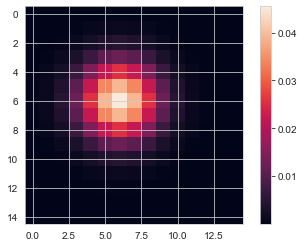

In [434]:
plt.imshow(np.reshape(w, (D,D)), vmin = min(w), vmax = max(w))
plt.colorbar()
plt.show()

Plot the responses of the cell.

Text(0.5, 1.0, 'Simulated response of cell')

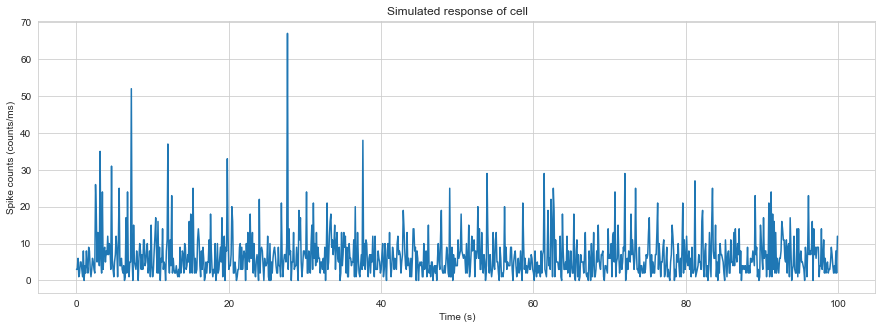

In [435]:
plt.figure(figsize=(15,5))

t = np.arange(0,nT) * dt

plt.plot(t, c)
plt.xlabel("Time (s)")
plt.ylabel("Spike counts (counts/ms)")
plt.title("Simulated response of cell")

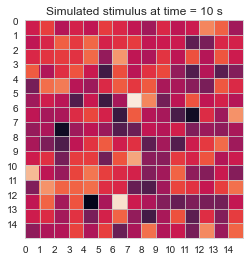

In [436]:
plt.imshow(np.reshape(s[:, 100], (D,D)), extent=[0, 15, 15, 0])
plt.xticks(np.arange(0, 15))
plt.yticks(np.arange(0, 15))
plt.title("Simulated stimulus at time = 10 s")
plt.show()

Text(0, 0.5, 'c')

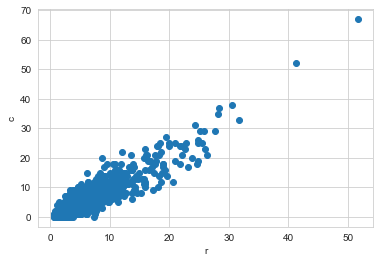

In [437]:
plt.scatter(r.flatten(), c.flatten())
plt.xlabel("r")
plt.ylabel("c")

### Implementation 

Before you run your optimizer, make sure the gradient is correct. The helper function `check_grad` in `scipy.optimize` can help you do that. This package also has suitable functions for optimization. If you generate a large number of  samples, the fitted receptive field will look more similar to the true receptive field. With more samples, the optimization takes longer, however.

*(2 pts)*


In [427]:
def logLikeLnp(x, c, s, dt, R):
    '''
      Plot spike rasters for a single neuron sorted by condition

      f, df = logLikLnp(x,c,s)
       Implements the negative (!) log-likelihood of the LNP model and its
       gradient with respect to the receptive field w.

       x   current receptive field (225 x 1)
       c   spike counts (1 x T/dt)
       s   stimulus matrix (225 x T/dt)

       f   function value of the negative log likelihood at x (scalar)
       df  gradient of the negative log likelihood with respect to x (225 x 1)

    '''
    r = np.exp(x.T@s)*dt*R
    f = -1 * np.sum(np.multiply(c, np.log(r)) - r)
    df = (r-c)@(s.T)#-1 * s@((c-r).reshape(-1, 1))
    
    return f, df

In [428]:
from scipy.optimize import check_grad
func = lambda x: logLikeLnp(x, c, s, dt, R)[0]
grad = lambda x: logLikeLnp(x, c, s, dt, R)[1].flatten()
check_grad(func, grad, w)

0.018168660826130598

Fit receptive field maximizing the log likelihood

In [429]:
# enter optimization code here
x0_ = np.random.uniform(low=0, high=1, size=(D*D)).flatten()
x0 = x0_/np.sum(x0_.flatten())

w_opt = opt.minimize(logLikeLnp, method='Newton-CG', x0=x0, args=(c, s, dt, R), jac=True, options={'disp': True}).x

Optimization terminated successfully.
         Current function value: -7626.960169
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 38
         Hessian evaluations: 0


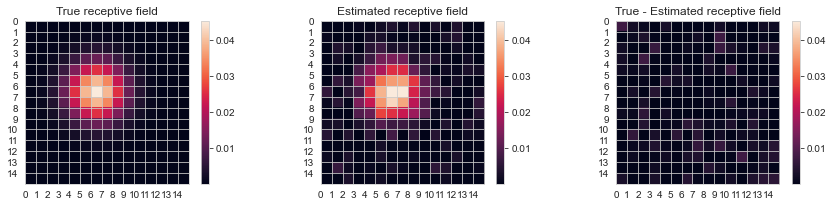

In [430]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))

plot1 = ax[0].imshow(np.reshape(w, (D,D)), vmin = min(w), vmax = max(w), extent=[0, 15, 15, 0])
plt.colorbar(plot1,ax=ax[0])
ax[0].set_xticks(np.arange(0, 15))
ax[0].set_yticks(np.arange(0, 15))
ax[0].set_title("True receptive field")


plot2 = ax[1].imshow(np.reshape(w_opt, (D,D)), vmin = min(w), vmax = max(w), extent=[0, 15, 15, 0])
plt.colorbar(plot2,ax=ax[1])
ax[1].set_xticks(np.arange(0, 15))
ax[1].set_yticks(np.arange(0, 15))
ax[1].set_title("Estimated receptive field")


w_diff = w-w_opt
plot3 = ax[2].imshow(np.reshape(w_diff, (D,D)), vmin = min(w), vmax = max(w), extent=[0, 15, 15, 0])
plt.colorbar(plot3,ax=ax[2])
ax[2].set_xticks(np.arange(0, 15))
ax[2].set_yticks(np.arange(0, 15))
ax[2].set_title("True - Estimated receptive field")


# fig.tight_layout()
plt.show()

## Task 2: Apply to real neuron

Download the dataset for this task from Ilias (`nda_ex_6_data.mat`). It contains a stimulus matrix (`s`) in the same format you used before and the spike times. In addition, there is an array called `trigger` which contains the times at which the stimulus frames were swapped.

* Generate an array of spike counts at the same temporal resolution as the stimulus frames
* Fit the receptive field with time lags of 0 to 4 frames. Fit them one lag at a time (the ML fit is very sensitive to the number of parameters estimated and will not produce good results if you fit the full space-time receptive field for more than two time lags at once). To this end, shift the stimulus array accordingly, such that you can use your instantaneous plotting function from above.
* Plot the resulting filters.

*Grading: 2 pts*


In [311]:
var = io.loadmat('../data/nda_ex_6_data.mat')

# t contains the spike times of the neuron
t = var['DN_spiketimes'].flatten()    

# trigger contains the times at which the stimulus flipped
trigger = var['DN_triggertimes'].flatten()

# contains the stimulus movie with black and white pixels
s = var['DN_stim']
s = s.reshape((300,1500))
s = s[:,1:len(trigger)]


Create vector of spike counts

In [360]:
c, b = np.histogram(t,bins=trigger)

Fit receptive field for each frame separately

In [351]:
dt = np.diff(trigger)

lags = range(5)

w_opt_lag = np.zeros((s.shape[0], np.size(lags)))

for lag in lags:
    print(lag)
    x0_ = np.random.uniform(low=0, high=1, size=s.shape[0]).flatten()
    x0 = x0_/np.sum(x0_.flatten())

    if lag > 0:
        c_ = c[lag:]
        s_ = s[:, :-lag]
        dt_ = dt[:-lag]

        w_opt_lag[:, lag] = opt.minimize(logLikeLnp, method='Newton-CG', x0=x0, args=(c_, s_, dt_, R), jac=True, options={'disp': True}).x

    else:
        w_opt_lag[:, lag] = opt.minimize(logLikeLnp, method='Newton-CG', x0=x0, args=(c, s, dt, R), jac=True, options={'disp': True}).x

0
Optimization terminated successfully.
         Current function value: -1834.168325
         Iterations: 15
         Function evaluations: 17
         Gradient evaluations: 62
         Hessian evaluations: 0
1
Optimization terminated successfully.
         Current function value: -1842.396656
         Iterations: 16
         Function evaluations: 20
         Gradient evaluations: 68
         Hessian evaluations: 0
2
Optimization terminated successfully.
         Current function value: -1793.622662
         Iterations: 16
         Function evaluations: 19
         Gradient evaluations: 73
         Hessian evaluations: 0
3
Optimization terminated successfully.
         Current function value: -1809.107844
         Iterations: 15
         Function evaluations: 18
         Gradient evaluations: 69
         Hessian evaluations: 0
4
Optimization terminated successfully.
         Current function value: -1790.687031
         Iterations: 16
         Function evaluations: 19
         Gradien

Plot the frames one by one

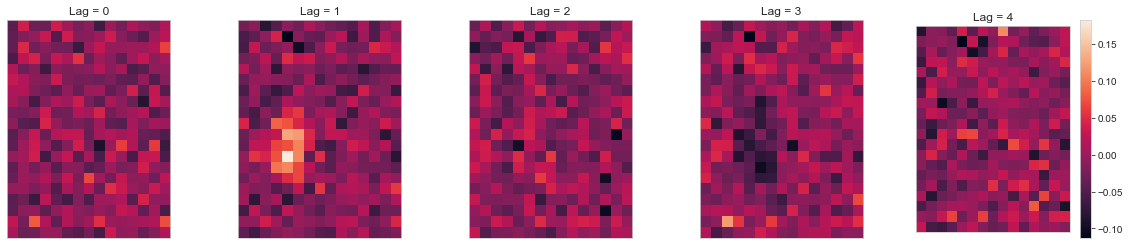

In [359]:
fig, ax = plt.subplots(1, 5, figsize=(20, 4))

for lag in lags:
    _ = ax[lag].imshow(np.reshape(w_opt_lag[:, lag], (20, 15)), vmin=np.min(w_opt_lag), vmax=np.max(w_opt_lag))
    ax[lag].set_title(f"Lag = {lag}")
    ax[lag].set_xticks([])
    ax[lag].set_yticks([])

plt.colorbar(_, ax=ax[-1])

## Task 3: Separate space/time components

The spatiotemporal receptive field of the neuron can be decomposed into a spatial and a temporal component. Because of the way we computed them above, these two components are independent and thus the receptive field can be called space-time separable. You can use singular-value decomposition to separate the spatial and temporal components: 

$$
W = u_1 s_1 v_1^T
$$

Here $u_1$ and $v_1$ are the singular vectors belonging to the 1st singular value $s_1$ and provide a long rank approximation of W, the array with all receptive fields. It is important that the mean is subtracted before computing the SVD. Collect the space-time receptive field computed as in Task 2 in a matrix $W$ before applying SVD.  

Plot the first temporal component and the first spatial component. You can use a Python implementation of SVD. The results can look a bit puzzling, because the sign of the components is arbitrary.

*Grading: 1 pts*

In [418]:
u, sv, v = np.linalg.svd(w_opt_lag.T)

Text(0.5, 1.0, 'First spatial component \n(Receptive field)')

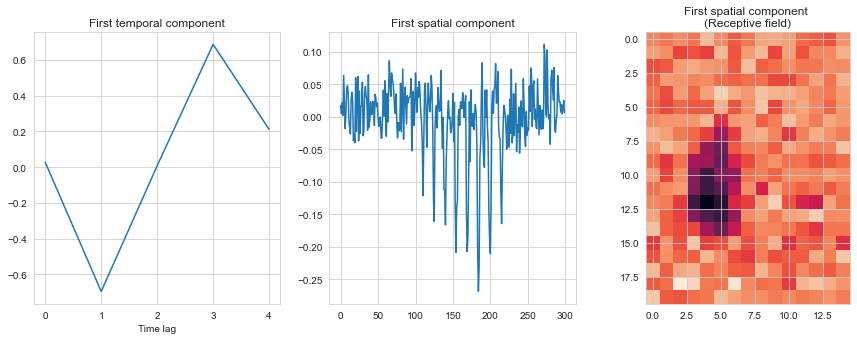

In [420]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].plot(u[:, 1])
ax[0].set_xlabel("Time lag")
ax[0].set_title("First temporal component")

ax[1].plot(v[1, :])
ax[1].set_title("First spatial component")

ax[2].imshow(np.reshape(v[1, :], (20, 15)))
ax[2].set_title("First spatial component \n(Receptive field)")

## Task 4: Regularized receptive field

As you can see, maximum likelihood estimation of linear receptive fields can be quite noisy, if little data is available. 

To improve on this, one can regularize the receptive field vector and a term to the cost function


$$
C(w) = L(w) + \alpha ||w||_p^2
$$

Here, the $p$ indicates which norm of $w$ is used: for $p=2$, this is shrinks all coefficient equally to zero; for $p=1$, it favors sparse solutions, a penality also known as lasso. Because the 1-norm is not smooth at zero, it is not as straightforward to implement "by hand". 

Use a toolbox with an implementation of the lasso-penalization and fit the receptive field. Possibly, you will have to try different values of the regularization parameter $\alpha$. Plot your estimates from above and the lasso-estimates. How do they differ? What happens when you increase or decrease $alpha$?

To keep the Poisson noise model, you can use the implementation in [`RFEst`](https://github.com/berenslab/RFEst) or  [`pyglmnet`](https://pypi.python.org/pypi/pyglmnet) (the latter was a bit slow). Otherwise, you can also resort to the linear Haussian model from `sklearn`.

*Grading: 2 pts*


In [378]:
import sklearn

In [379]:
from sklearn import linear_model

In [403]:
import warnings
warnings.filterwarnings('ignore')

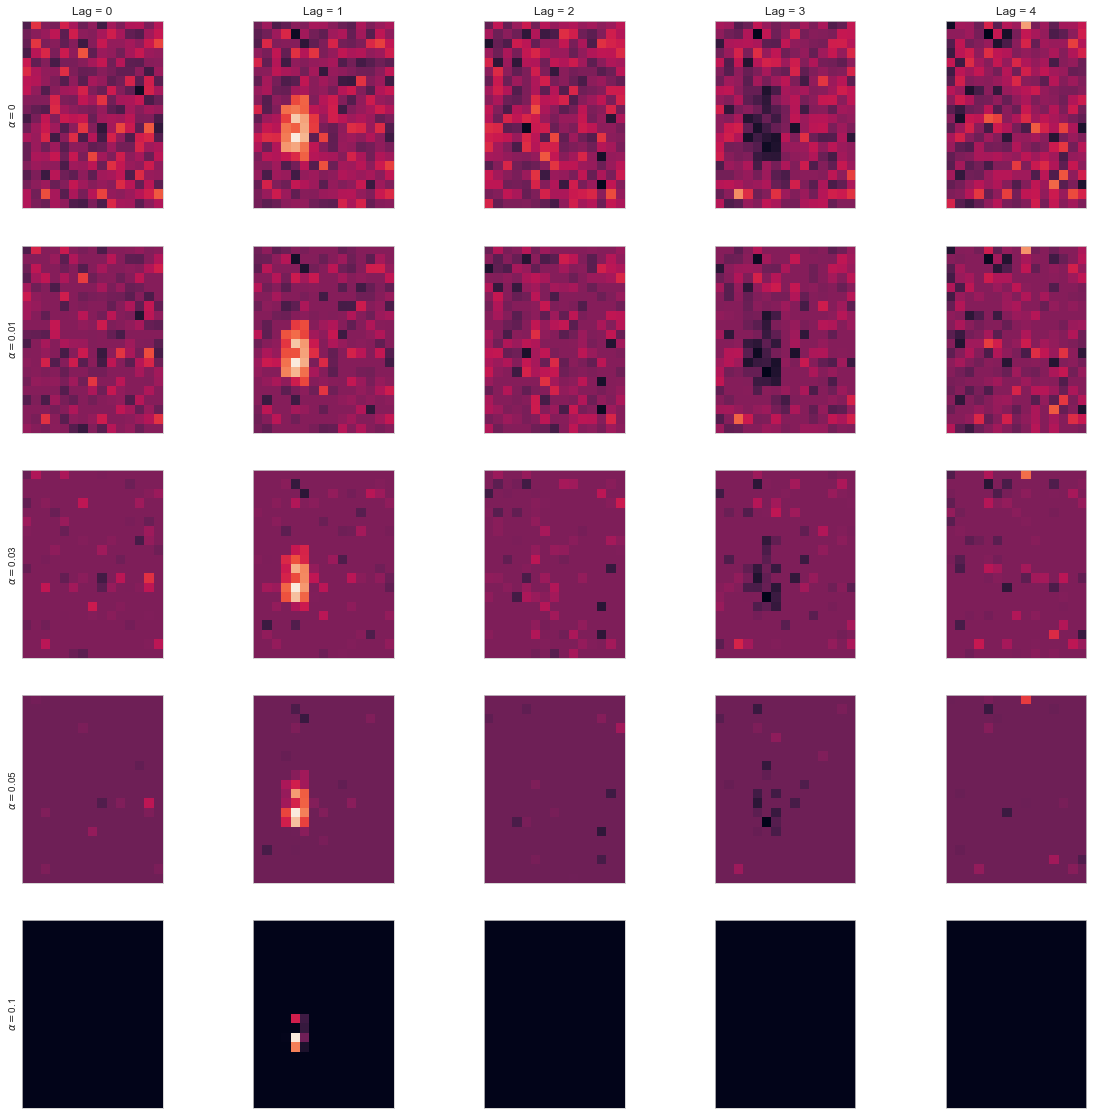

In [412]:
fig, ax = plt.subplots(5, 5, figsize=(20, 20))

alphas = (0, 0.01, 0.03, 0.05, 0.1)

for row, alpha in enumerate(alphas):
    reg = linear_model.Lasso(alpha=alpha)

    w_opt_lag_reg = np.zeros((s.shape[0], np.size(lags)))

    for lag in lags:
        if lag > 0:
            c_ = c[lag:]
            s_ = s[:, :-lag]
            reg.fit(s_.T, c_)
            w_opt_lag_reg[:, lag] = reg.coef_

        else:
            reg.fit(s.T, c)
            w_opt_lag_reg[:, lag] = reg.coef_
            
    for lag in lags:
        _ = ax[row][lag].imshow(np.reshape(w_opt_lag_reg[:, lag], (20, 15)), vmin=np.min(w_opt_lag_reg), vmax=np.max(w_opt_lag_reg))
        ax[row][lag].set_xticks([])
        ax[row][lag].set_yticks([])
        
for lag in lags:
    ax[0][lag].set_title(f"Lag = {lag}")
    
for row in range(len(alphas)):
    ax[row][0].set_ylabel(r'$\alpha = ${}'.format(alphas[row]))

We find that imposing a Lasso penalty makes the receptive field more sparse, and the sparseness increases as alpha is increased. Imposing the penalty reduces the noise (a lot of noise can be seen in the unregularized case where alpha = 0) and makes the structure in the receptive field more clear (alpha = 0.3 is a good example of this).